In [28]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Generate Random Data

In [122]:
def generate_linear_3d_structure(num_points, distance_threshold, linearity=5):
    # 生成线性分布的点，加入小的随机扰动
    t = np.linspace(0, num_points - 1, num_points)
    x = t + np.random.normal(0, linearity, num_points)
    y = np.random.normal(0, linearity, num_points)
    z = np.random.normal(0, linearity, num_points)
    points = np.vstack((x, y, z)).T

    # 计算点对之间的距离
    dist_matrix = np.linalg.norm(points[:, np.newaxis] - points, axis=2)

    # 确定距离小于阈值的点对
    contacts = np.argwhere((dist_matrix < distance_threshold) & (dist_matrix > 0))
    contacts = contacts[contacts[:, 0] < contacts[:, 1]]  # 避免重复

    return points, contacts

def downsample_contacts(contacts, downsampling_rate):
    # 随机选择部分contacts进行保留
    num_to_keep = int(len(contacts) * downsampling_rate)
    indices = np.random.choice(len(contacts), num_to_keep, replace=False)
    downsampled_contacts = contacts[indices]
    
    return downsampled_contacts


def save_contacts_to_csv(contacts, file_path):
    # 创建DataFrame
    df = pd.DataFrame(contacts, columns=['pos1', 'pos2'])
    df['chrom1'] = 'chr1'
    df['chrom2'] = 'chr1'
    df = df[['chrom1', 'pos1', 'chrom2', 'pos2']]
    
    # 保存到CSV
    df.to_csv(file_path, index=False, header=None)

np.random.seed(42)
points, contacts = generate_linear_3d_structure(num_points=10, distance_threshold=4, linearity=2)
downsampling_rate = 0.50  # 保留20%的contacts
downsampled_contacts = downsample_contacts(contacts, downsampling_rate)

save_contacts_to_csv(downsampled_contacts, 'test.pairs')


# chromosome length
chr_len_data = {'chrom': ['chr1'], 'length': [len(points)]}
df_chr_len = pd.DataFrame(chr_len_data)
df_chr_len.to_csv('chr.len', index=False,header=None)

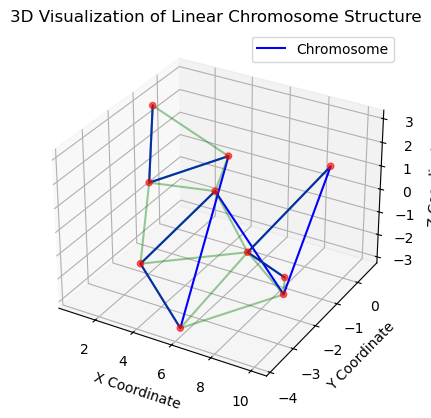

In [123]:
def visualize_linear_structure(points, contacts):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'b-', label='Chromosome')  # 绘制线
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', alpha=0.6)  # 绘制点

    for contact in contacts:
        p1, p2 = contact
        ax.plot([points[p1, 0], points[p2, 0]], 
                [points[p1, 1], points[p2, 1]], 
                [points[p1, 2], points[p2, 2]], 'g-', alpha=0.4)  # 绘制联系线

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title('3D Visualization of Linear Chromosome Structure')
    plt.legend()
    plt.show()

visualize_linear_structure(points, contacts)

## FDG simple

In [124]:
def load_chromosome_lengths(file_path):
    df_lengths = pd.read_csv(file_path, header=None, names=['chrom', 'length'])
    df_lengths['length'] = df_lengths['length'].astype(int)  # 确保长度是整数类型
    return df_lengths

def load_pairs(file_path, bin_size):
    # 读取pairs文件
    df_pairs = pd.read_csv(file_path, header=None, names=['chrom1', 'pos1', 'chrom2', 'pos2'])
    # 计算bin索引
    df_pairs['bin1'] = df_pairs['pos1'] // bin_size
    df_pairs['bin2'] = df_pairs['pos2'] // bin_size
    return df_pairs

def create_node_index(df_lengths, bin_size):
    node_indices = {}
    current_index = 0
    for _, row in df_lengths.iterrows():
        num_bins = (row['length'] // bin_size) + 1  # 使用整除确保结果为整数
        node_indices[row['chrom']] = list(range(current_index, current_index + num_bins))
        current_index += num_bins
    return node_indices

def create_forces(df_pairs, node_indices):
    # 创建力矩阵
    forces = []
    for _, row in df_pairs.iterrows():
        index1 = node_indices[row['chrom1']][row['bin1']]
        index2 = node_indices[row['chrom2']][row['bin2']]
        forces.append([index1, index2])
    return np.array(forces)

In [125]:
def init_graph(num_nodes,seed=None):
    if seed is not None:
        np.random.seed(seed)
    return (np.random.uniform(-100, 100, (num_nodes, 3)), np.zeros((num_nodes, 3), dtype=float))

def update_graph(positions, velocities, forces, force_constant, friction):
    num_nodes = positions.shape[0]
    force_values = np.zeros((num_nodes, 3), dtype=float)

    # Calculate spring forces (attraction or repulsion based on equilibrium distance)
    for idx1, idx2 in forces:
        displacement = positions[idx2] - positions[idx1]
        distance = np.linalg.norm(displacement)
        if distance > 0:
            # Spring force: F = -k (x - 1) * (u / |u|)
            force = -force_constant * (distance - 1.0) * displacement / distance
            force_values[idx2] += force
            force_values[idx1] -= force

    # Calculate collision forces using kdtree, ensuring only repulsion
    kdtree = cKDTree(positions)
    index_pairs = kdtree.query_pairs(5)  # Get pairs within unit distance
    for idx1, idx2 in index_pairs:
        displacement = positions[idx2] - positions[idx1]
        distance = np.linalg.norm(displacement)
        if distance > 0:
            # Collision force (repulsion only): F = k * (1 - x) * (u / |u|)
            # Ensures that nodes are pushed apart if they are too close
            force = force_constant * (1.0 - distance) * displacement / distance
            force_values[idx2] += force
            force_values[idx1] -= force

    # Apply forces to velocities, consider friction
    velocities += force_values
    velocities *= (1 - friction)  # Reduce velocity by friction factor
    positions += velocities  # Update positions based on new velocities

    return positions, velocities

In [126]:
def run_simulation(pairs_file, chr_len_file, bin_size, force_constant, friction, max_steps, output_prefix):
    df_lengths = load_chromosome_lengths(chr_len_file)
    df_pairs = load_pairs(pairs_file, bin_size)
    node_indices = create_node_index(df_lengths, bin_size)
    forces = create_forces(df_pairs, node_indices)
    
    num_nodes = sum((length // bin_size + 1 for length in df_lengths['length']))
    positions, velocities = init_graph(num_nodes)
    
    for step in range(max_steps):
        positions, velocities = update_graph(positions, velocities, forces, force_constant, friction)
        if (step + 1) % 100 == 0:
            print(f"Step {step + 1}: positions updated.")
            np.savetxt(f"{output_prefix}{step + 1}.txt", positions)

In [127]:
run_simulation('test.pairs', 'chr.len', 1, 0.01, 0.1, 500, 'output_')

Step 100: positions updated.
Step 200: positions updated.
Step 300: positions updated.
Step 400: positions updated.
Step 500: positions updated.


In [128]:
def visualize_simulation_results(file_path):
    # 加载数据
    data = np.loadtxt(file_path)
    
    # 创建3D图形
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制散点图
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], color='blue', alpha=0.5, label='Beads')  # 珠子表示为点
    
    # 连接相邻点，模拟线性染色体结构
    ax.plot(data[:, 0], data[:, 1], data[:, 2], color='red', linewidth=1, label='String')  # 连接线表示染色体线性结构
    
    # 设置标签
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    
    # 设置标题
    ax.set_title('3D Visualization of Simulation Results: Beads on a String')
    
    # 添加图例
    ax.legend()
    
    # 显示图形
    plt.show()

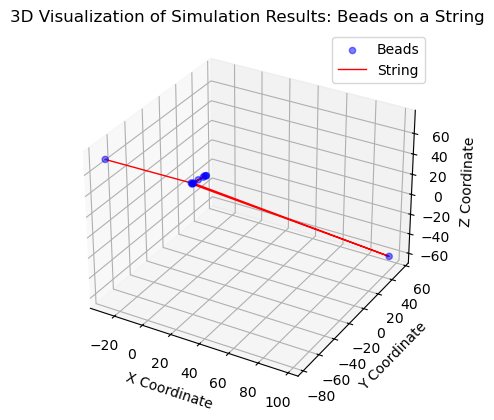

In [129]:
visualize_simulation_results('output_100.txt')

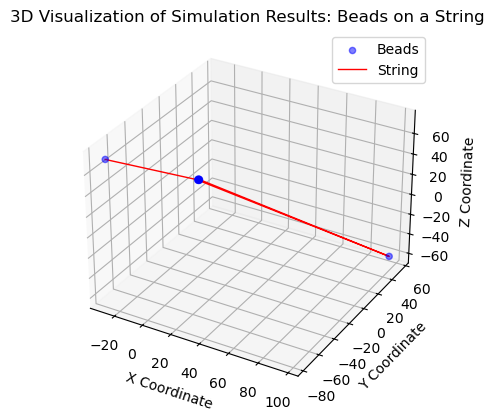

In [130]:
visualize_simulation_results('output_500.txt')